In [29]:
from dataclasses import dataclass
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal
from sklearn.model_selection import train_test_split
from ssqueezepy import Wavelet, cwt
from ssqueezepy.utils import make_scales, cwt_scalebounds
from ssqueezepy.visuals import imshow


In [30]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './ctu-data_csv'
    meta = 'metadata.csv'
    first = './ctu-outputs/daydulo_cwt_first_stage'
    second = './ctu-outputs/daydulo_cwt_second_stage'
    train = 'train'
    test = 'test'
    normal = 'class_0_normal'
    distress = 'class_1_distressed'


paths = Paths()

In [31]:
# Set up dictionary for CSV files
csv_files = dict()

# Load files into dictionary, but remove metadata
filenames = os.listdir(paths.data)
filenames.remove(paths.meta)
for file in filenames:
    # Get filename and file extension
    filename, file_extension = os.path.splitext(os.path.join(paths.data, file))
    # Load data and save to dict with filename (without path/csv) as index
    if file_extension == '.csv':
        filename_short = filename.split(os.sep)[-1]
        csv_files[filename_short] = pd.read_csv(os.path.join(paths.data, file))

In [32]:
# Load meta data and transform
metadata = pd.read_csv(os.path.join(paths.data, paths.meta),
                       index_col='parameter')
csv_index = list(metadata)
metadata.head()

,1220,1234,1208,1038,1004,1010,1022,1036,2041,1206,...,1079,1290,1284,1077,1063,1088,1253,1247,2028,2014
parameter,,,,,,,,,,,,,,,,,,,,,
pH,7.30,7.29,7.23,7.33,7.30,7.35,7.28,7.08,7.37,7.24,...,7.17,7.36,7.16,7.22,7.16,7.25,7.32,7.32,7.18,7.32
BDecf,3.52,2.50,5.84,2.72,5.19,5.20,1.53,8.11,3.69,2.06,...,7.91,3.88,5.07,6.69,5.56,2.58,0.89,-0.86,4.82,2.28
pCO2,6.00,6.50,6.60,5.70,5.50,4.70,7.00,9.30,4.80,7.70,...,7.10,4.90,8.50,6.50,8.30,7.30,6.40,6.90,8.10,6.00
BE,-4.70,-4.20,-7.40,-4.00,-6.40,-5.90,-3.00,-11.20,-3.10,-4.00,...,-9.90,-4.10,-7.30,-8.00,-7.90,-4.50,-1.70,-1.00,-7.20,-3.20
Apgar1,9.00,8.00,9.00,10.00,8.00,8.00,10.00,8.00,9.00,9.00,...,8.00,9.00,10.00,6.00,9.00,8.00,8.00,9.00,8.00,10.00


In [33]:
ph = metadata[metadata.index == 'pH'].T
ph['class'] = np.where(ph['pH'] <= 7.15, 1, 0)
ph['class'].value_counts()

0    439
1    113
Name: class, dtype: int64

In [34]:
# Get list of ID in distressed class
distress_records = ph[ph['class'] == 1].index.tolist()
print(f'Preview records{distress_records[0:5]}')

# Filter dictionary to those ID, and double-check length is correct
csv_distress = dict((k, csv_files[k]) for k in distress_records)

# Double-check its the correct length
print(f'Checking dictionary length: {len(csv_distress)}')


# Get list of ID in normal class
normal_records = ph[ph['class'] == 0].index.tolist()
print(f'Preview records{normal_records[0:5]}')

# Filter dictionary to those ID, and double-check length is correct
csv_normal = dict((k, csv_files[k]) for k in normal_records)

# Double-check its the correct length
print(f'Checking dictionary length: {len(csv_normal)}')

Preview records['1036', '1156', '1400', '1426', '1158']
Checking dictionary length: 113
Preview records['1220', '1234', '1208', '1038', '1004']
Checking dictionary length: 439


In [35]:
def daydulo_clean(fhr):
    '''
    Cleans fetal heart rate (FHR) signal according to Daydulo et al. 2022
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    '''

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(61) & na)].reset_index(drop=True)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using cubic interpolation
    fhr = fhr.interpolate(method='cubic')

    return(fhr)

In [36]:
def clean_signals(sig_dict):
    '''
    Cleans signals in provided dictionary, and returns two (one representing
    first stage and one representing second stage)
    Inputs:
    - sig_dict - dictionary of dataframes which have FHR column for cleaning
    Outputs:
    - fhr_first - dictionary of clean FHR signals for first stage of labour
    - fhr_second - dictionary of clean FHR signals for second stage of labour
    '''
    fhr_first = dict()
    fhr_second = dict()
    for key, value in sig_dict.items():
        df = daydulo_clean(value.FHR)
        fhr_first[key] = df.head(4800)
        fhr_second[key] = df.tail(3600).reset_index(drop=True)

    return(fhr_first, fhr_second)

In [37]:
# Apply cleaning to the signals
fhr_normal_first, fhr_normal_second = clean_signals(csv_normal)
fhr_distress_first, fhr_distress_second = clean_signals(csv_distress)

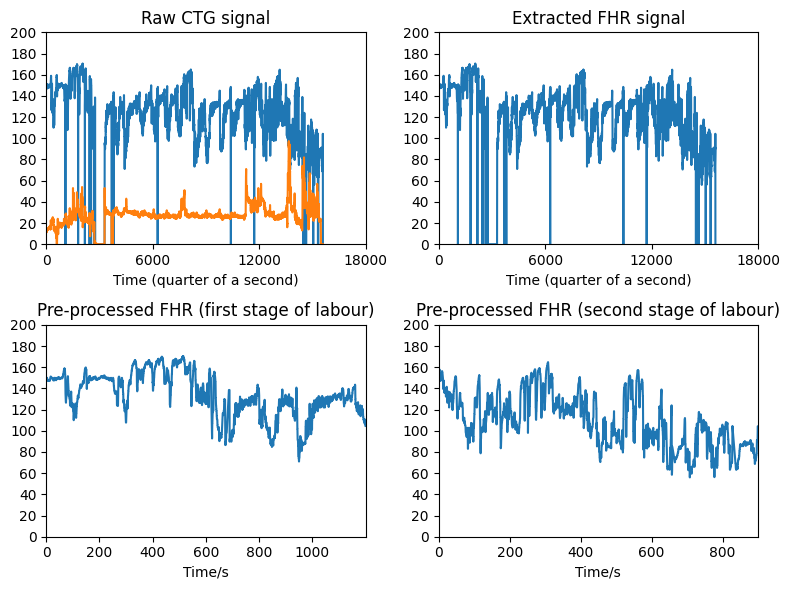

In [38]:
# Initialise plot
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 6))

# Plot raw FHR and UC
ax[0,0].plot(csv_files['1011'].FHR.fillna(0))
ax[0,0].plot(csv_files['1011'].UC.fillna(0))
ax[0,0].margins(x=0)
ax[0,0].set_ylim(0, 200)
ax[0,0].set_xlabel('Time (quarter of a second)')
ax[0,0].set_title('Raw CTG signal')
ax[0,0].set_xticks([0, 6000, 12000, 18000])
ax[0,0].set_yticks(np.arange(0, 201, 20))

# Plot raw FHR
ax[0,1].plot(csv_files['1011'].FHR.fillna(0))
ax[0,1].margins(x=0)
ax[0,1].set_ylim(0, 200)
ax[0,1].set_xlabel('Time (quarter of a second)')
ax[0,1].set_title('Extracted FHR signal')
ax[0,1].set_xticks([0, 6000, 12000, 18000])
ax[0,1].set_yticks(np.arange(0, 201, 20))

# Plot clean FHR stage 1
ax[1,0].plot(fhr_normal_first['1011'].index/4, fhr_normal_first['1011'])
ax[1,0].margins(x=0)
ax[1,0].set_ylim(0, 200)
ax[1,0].set_xlabel('Time/s')
ax[1,0].set_title('Pre-processed FHR (first stage of labour)')
ax[1,0].set_yticks(np.arange(0, 201, 20))

# Plot clean FHR stage 2
ax[1,1].plot(fhr_normal_second['1011'].index/4, fhr_normal_second['1011'])
ax[1,1].margins(x=0)
ax[1,1].set_ylim(0, 200)
ax[1,1].set_xlabel('Time/s')
ax[1,1].set_title('Pre-processed FHR (second stage of labour)')
ax[1,1].set_yticks(np.arange(0, 201, 20))

plt.tight_layout()
plt.show()

In [39]:
# Loop through those files, clean, and append the slices to the right dictionary
# With key name modified as _5 or _10 depending on the slice
# Have to use raw data as we clipped when saving to e.g. fhr_distress_first
for key, value in csv_distress.items():
    df = daydulo_clean(value.FHR)
    fhr_distress_first[f'{key}_5'] = df[1200:6000]
    fhr_distress_first[f'{key}_10'] = df[2400:7200]
    fhr_distress_second[f'{key}_5'] = df[-4800:-1200]
    fhr_distress_second[f'{key}_10'] = df[-6000:-2400]

In [40]:
print(f'''Total normal signals: {
    len(fhr_normal_first) + len(fhr_normal_second)}''')
print(f'''Total distressed signals: {
    len(fhr_distress_first) + len(fhr_distress_second)}''')
print(f'''Total records: {
    len(fhr_normal_first) + len(fhr_normal_second) +
    len(fhr_distress_first) + len(fhr_distress_second)}''')

Total normal signals: 878
Total distressed signals: 678
Total records: 1556


In [41]:
def daydulo_cwt(fhr, beta, axes):
    '''
    Perform CWT and plot scaleogram for replicating Daydulo at given values
    of beta and p2
    - fhr: series, FHR signal
    - beta: number, decay/compactness parameter, relates to p2, used for CWT
    - axes: axis object
    '''
    # Set parameters
    signal_length = len(fhr)
    wavelet = Wavelet(('gmw', {'gamma': 3, 'beta':beta}))
    voices_per_octave = 12

    # Find scales
    min_scale, max_scale = cwt_scalebounds(wavelet, signal_length)
    scales = make_scales(signal_length, scaletype='log', nv=voices_per_octave,
                        min_scale=min_scale, max_scale=max_scale)

    # Perform CWT
    Wx, _ = cwt(fhr, wavelet, scales=scales)

    # Visualise results in a scaleogram
    imshow(data=Wx, abs=1, show=False, yticks=1/scales, ax=axes,
           xlabel='Time (quarter of a second)', ylabel='Frequency')

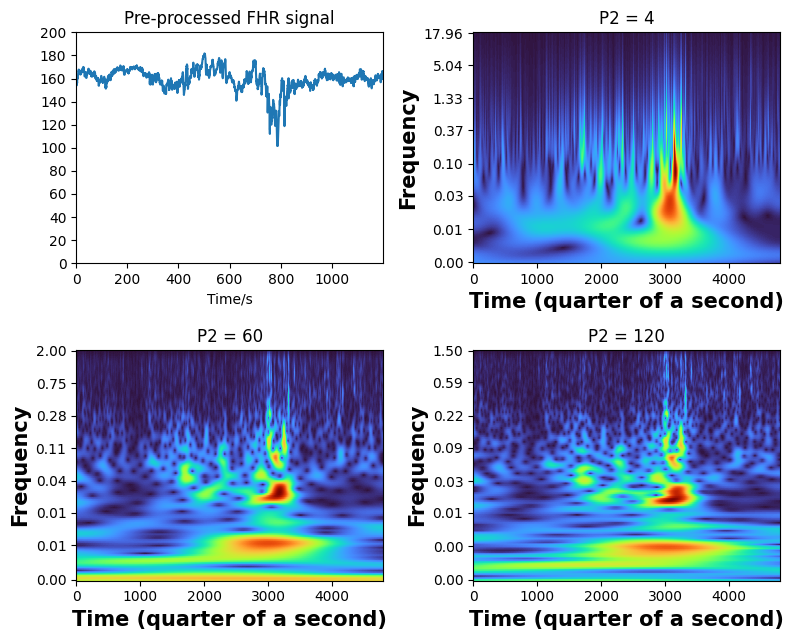

In [42]:
# Initialise plot
fig, ax = plt.subplots(2, 2, figsize=(8, 6.5))

# Plot clean FHR stage 1
ax[0,0].plot(fhr_distress_first['1017'].index/4,
             fhr_distress_first['1017'])
ax[0,0].margins(x=0)
ax[0,0].set_ylim(0, 200)
ax[0,0].set_xlabel('Time/s')
ax[0,0].set_title('Pre-processed FHR signal')
ax[0,0].set_yticks(np.arange(0, 201, 20))

# Plot CWT with different parameters
daydulo_cwt(fhr_distress_first['1017'], beta=0.75, axes=ax[0,1])
ax[0,1].set_title('P2 = 4')
daydulo_cwt(fhr_distress_first['1017'], beta=20, axes=ax[1,0])
ax[1,0].set_title('P2 = 60')
daydulo_cwt(fhr_distress_first['1017'], beta=40, axes=ax[1,1])
ax[1,1].set_title('P2 = 120')

plt.tight_layout()
plt.show()

In [43]:
summary_first = pd.DataFrame({
    'class': ['normal']*2 + ['distress']*2,
    'stage': ['first']*4,
    'set': ['train', 'test']*2,
    'records': [ (790*0.9)/2, (790*0.1)/2+88/2, (610*0.9)/2, (610*0.1)/2 + 68/2]
})
summary_second = summary_first.copy()
summary_second['stage'] = 'second'
summary_all = pd.concat([summary_first, summary_second])
summary_all

,class,stage,set,records
0,normal,first,train,355.5
1,normal,first,test,83.5
2,distress,first,train,274.5
3,distress,first,test,64.5
0,normal,second,train,355.5
1,normal,second,test,83.5
2,distress,second,train,274.5
3,distress,second,test,64.5


In [44]:
print(f'''
Checking values...
Total records: {summary_all['records'].sum()}
Total test: {summary_all.loc[summary_all['set'] == 'test', 'records'].sum()}
Total train: {summary_all.loc[summary_all['set'] == 'train', 'records'].sum()}
''')


Checking values...
Total records: 1556.0
Total test: 296.0
Total train: 1260.0



In [45]:
def apply_cwt(dict, file_path):
    '''
    Apply CWT to traces in the provided dictionary, saving files in the
    provided file path.
    Inputs:
    dict - dictionary of FHR signals, where record name will be image name
    file_path - path to folder to store the produced scaleograms
    '''
    for key, value in dict.items():

        # Perform CWT
        fig, ax = plt.subplots()
        daydulo_cwt(value, beta=20, axes=ax)

        # Remove axis and borders, and save as PNG file using record name
        plt.axis('off')
        plt.savefig(f'{file_path}/{key}.png',
                    bbox_inches='tight', pad_inches=0)

        # Close figure else struggles since creating lots in a loop
        plt.close(fig)

In [46]:
def train_test_cwt(dict, path_stage, path_class):
    '''
    Splits the dataset into training, validation and test data, and then
    performs CWT on each of those datasets and saves in the appropriate folders
    Inputs:
    dict - dictionary with FHR (either normal or distressed, and first or second stage)
    path_stage - path to folder with appropriate stage
    path_class - name of folder for appropriate class
    '''
    # Split the overall dataset into 90% train(/validate) and 10% test
    temp, test = train_test_split(
        list(dict.keys()),train_size=0.9, random_state=42)
    test_dict = {key: dict[key] for key in test}

    # Split the train/valdiation data into 90% train 10% validate
    train, valid = train_test_split(temp,train_size=0.9, random_state=42)
    train_dict = {key: dict[key] for key in train}
    valid_dict = {key: dict[key] for key in valid}

    # Print the length of those subsets
    print(f'Train {len(train)}, test {len(test) + len(valid)}')

    # Create folder paths if they don't yet exist
    train_path = os.path.join(path_stage, paths.train, path_class)
    if not os.path.exists(train_path):
        os.makedirs(train_path)

    test_path = os.path.join(path_stage, paths.test, path_class)
    if not os.path.exists(test_path):
        os.makedirs(test_path)

    # Perform CWT and save the scaleograms
    apply_cwt(train_dict, train_path)
    apply_cwt(valid_dict, test_path)
    apply_cwt(test_dict, test_path)

In [47]:
%%time
train_test_cwt(fhr_distress_first, paths.first, paths.distress)

Train 274, test 65
CPU times: user 2min, sys: 1.58 s, total: 2min 2s
Wall time: 40.5 s


In [48]:
%%time
train_test_cwt(fhr_distress_second, paths.second, paths.distress)

Train 274, test 65
CPU times: user 1min 47s, sys: 1.23 s, total: 1min 48s
Wall time: 35.9 s


In [49]:
%%time
train_test_cwt(fhr_normal_first, paths.first, paths.normal)

Train 355, test 84
CPU times: user 2min 33s, sys: 1.48 s, total: 2min 35s
Wall time: 51.4 s


In [50]:
%%time
train_test_cwt(fhr_normal_second, paths.second, paths.normal)

Train 355, test 84
CPU times: user 2min 20s, sys: 1.71 s, total: 2min 22s
Wall time: 47.1 s


## Check file numbers

Look at the number of output files in each directory and check it matches what we expected.

In [51]:
# Initalise counter for total files
N = 0
# Count number of files in all subdirectories of outputs
for dirpath, dirnames, filenames in os.walk('ctu-outputs', topdown=True):
    N_c = len(filenames)
    N += N_c
    print(f'Files in {dirpath}, {N_c}')
print(f'Total Files {N}')
print(f'Total Daydulo Files {N - 552 - 552 - 2}')

Files in ctu-outputs, 0
Files in ctu-outputs/daydulo_cwt_second_stage, 0
Files in ctu-outputs/daydulo_cwt_second_stage/test, 0
Files in ctu-outputs/daydulo_cwt_second_stage/test/class_0_normal, 84
Files in ctu-outputs/daydulo_cwt_second_stage/test/class_1_distressed, 65
Files in ctu-outputs/daydulo_cwt_second_stage/train, 0
Files in ctu-outputs/daydulo_cwt_second_stage/train/class_0_normal, 355
Files in ctu-outputs/daydulo_cwt_second_stage/train/class_1_distressed, 274
Files in ctu-outputs/daydulo_cwt_first_stage, 0
Files in ctu-outputs/daydulo_cwt_first_stage/test, 0
Files in ctu-outputs/daydulo_cwt_first_stage/test/class_0_normal, 84
Files in ctu-outputs/daydulo_cwt_first_stage/test/class_1_distressed, 65
Files in ctu-outputs/daydulo_cwt_first_stage/train, 0
Files in ctu-outputs/daydulo_cwt_first_stage/train/class_0_normal, 355
Files in ctu-outputs/daydulo_cwt_first_stage/train/class_1_distressed, 274
Total Files 1556
Total Daydulo Files 450


In [52]:
summary_all

,class,stage,set,records
0,normal,first,train,355.5
1,normal,first,test,83.5
2,distress,first,train,274.5
3,distress,first,test,64.5
0,normal,second,train,355.5
1,normal,second,test,83.5
2,distress,second,train,274.5
3,distress,second,test,64.5
